In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request as urllib

from datetime import datetime

import time
import ergo # Download from https://github.com/rethinkpriorities/ergo

def fetch(url):
    max_attempts = 80
    attempts = 0
    sleeptime = 10 #in seconds, no reason to continuously try if network is down

    while attempts < max_attempts:
        time.sleep(sleeptime)
        try:
            response = urllib.urlopen(url, timeout=5)
            content = response.read()
            return content
        except urllib.URLError as e:
            print(e)
            attempts += 1


/Users/peterhurford/.virtualenvs/dev/lib/python3.8/site-packages/ergo/ppl.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def kelly(user_odds, market_odds):
    return (user_odds - ((1 - user_odds) * (market_odds / (1 - market_odds))))

In [3]:
def compare_metaculus_vs_polymarket(polymarket_url, metaculus_qid, actual, inverse_pm=False):
    print('Fetching...')
    content = fetch(polymarket_url)
    print('Fetched')
    
    polymarket_df = pd.DataFrame(eval(str(content).split('"All":')[1].split('},"graphKeys":[')[0]))
    if inverse_pm:
        polymarket_df.columns = ['no_price', 'yes_price', 'time']
    else:
        polymarket_df.columns = ['yes_price', 'no_price', 'time']
    
    polymarket_df['yes_price'] = polymarket_df['yes_price'].astype(float)
    polymarket_df['no_price'] = polymarket_df['no_price'].astype(float)
    polymarket_df['time'] = polymarket_df['time'].apply(lambda t: t.split(',')[0])
    polymarket_df = polymarket_df[~((polymarket_df['yes_price'] == 0) & (polymarket_df['no_price'] == 0))]
    polymarket_df['polymarket_yes'] = polymarket_df['yes_price']
    polymarket_df = polymarket_df[['time', 'polymarket_yes']].drop_duplicates('time', keep='last')
    polymarket_df['time'] = polymarket_df['time'].apply(lambda t: t + ' 21' if ('Jan' in t or 'Feb' in t) else t + ' 20')
    polymarket_df['time'] = pd.to_datetime(polymarket_df['time'], format='%b %d %y')
    polymarket_df = polymarket_df.reset_index(drop=True)
    
    q = metaculus.get_question(metaculus_qid)
    metaculus_df = pd.DataFrame(q.data['metaculus_prediction']['history'])
    metaculus_df.columns = ['time', 'metaculus_yes']
    metaculus_df['time'] = pd.to_datetime(metaculus_df['time'].apply(lambda t: datetime.fromtimestamp(t)).dt.date)
    metaculus_df = metaculus_df.drop_duplicates('time', keep='last')
    metaculus_df = metaculus_df.reset_index(drop=True)
    metaculus_df
    
    merged_df = metaculus_df.merge(polymarket_df, on='time', how='left').dropna()
    merged_df['metaculus_brier'] = (merged_df['metaculus_yes'] - actual) ** 2
    merged_df['polymarket_brier'] = (merged_df['polymarket_yes'] - actual) ** 2
    merged_df['50_50_yes'] = merged_df['polymarket_yes'] * 0.5 + merged_df['metaculus_yes'] * 0.5
    merged_df['50_50_brier'] = (merged_df['50_50_yes'] - actual) ** 2
    
    bankroll = 1000
    metaculus_bets = []
    metaculus_winnings = []
    for index, row in merged_df.iterrows():
        if row['polymarket_yes'] == 0:
            row['polymarket_yes'] = 0.001
        if row['metaculus_yes'] == 0:
            row['metaculus_yes'] = 0.001
        if row['metaculus_yes'] > row['polymarket_yes']:
            bet = bankroll * kelly(row['metaculus_yes'], row['polymarket_yes'])
            shares = bet / row['polymarket_yes']
            winnings = shares if actual == 1 else -bet
        elif row['metaculus_yes'] < row['polymarket_yes']:
            bet = bankroll * kelly(1 - row['metaculus_yes'], 1 - row['polymarket_yes'])
            shares = bet / (1 - row['polymarket_yes'])
            winnings = shares if actual == 0 else -bet
        else:
            bet = 0
            shares = 0
        winnings += (bankroll - bet)
        metaculus_bets.append(bet)
        metaculus_winnings.append(winnings)
                
    polymarket_bets = []
    polymarket_winnings = []
    for index, row in merged_df.iterrows():
        if row['polymarket_yes'] > row['metaculus_yes']:
            bet = bankroll * kelly(row['polymarket_yes'], row['metaculus_yes'])
            shares = bet / row['metaculus_yes']
            winnings = shares if actual == 1 else -bet
        elif row['polymarket_yes'] < row['metaculus_yes']:
            bet = bankroll * kelly(1 - row['polymarket_yes'], 1 - row['metaculus_yes'])
            shares = bet / (1 - row['metaculus_yes'])
            winnings = shares if actual == 0 else -bet
        else:
            bet = 0
            shares = 0
            winnings = 0
        winnings += (bankroll - bet)
        polymarket_bets.append(bet)
        polymarket_winnings.append(winnings)
        
    merged_df['metaculus_bets'] = metaculus_bets
    merged_df['metaculus_winnings'] = metaculus_winnings
    merged_df['polymarket_bets'] = polymarket_bets
    merged_df['polymarket_winnings'] = polymarket_winnings
    
    return {'metaculus': metaculus_df,
            'polymarket': polymarket_df,
            'data': merged_df,
            'brier': merged_df[['metaculus_brier', 'polymarket_brier', '50_50_brier']].sum() / len(merged_df),
            'winnings': merged_df[['metaculus_winnings', 'polymarket_winnings']].sum() / len(merged_df)}


def plot_predictions(preds, q_title):
    plt.plot(preds['data']['time'], preds['data']['metaculus_yes'], label='Metaculus')
    plt.plot(preds['data']['time'], preds['data']['polymarket_yes'], label='Polymarket')
    plt.title(q_title)
    plt.legend()
    return plt

In [4]:
print('Logging in to Metaculus...')
metaculus = ergo.Metaculus()
metaculus.login_via_username_and_password(username='PeterHurford', password='GaZKQ6hEtZH0')
print('...Logged on')

Logging in to Metaculus...
...Logged on


## Trump Charges

In [5]:
# https://www.metaculus.com/questions/6222/criminal-charges-against-trump/
trump_charges = compare_metaculus_vs_polymarket('https://polymarket.com/market/donald-trump-federally-charged-by-february-20th',
                                                6222,
                                                actual=0)

Fetching...
Fetched


In [6]:
trump_charges['data']

,time,metaculus_yes,polymarket_yes,metaculus_brier,polymarket_brier,50_50_yes,50_50_brier,metaculus_bets,metaculus_winnings,polymarket_bets,polymarket_winnings
6,2021-01-20,0.262433,0.11,0.068871,0.0121,0.186217,0.034677,171.273563,657.452873,580.846150,1206.670809
7,2021-01-21,0.171291,0.10,0.029341,0.0100,0.135646,0.018400,79.212576,841.574849,416.199249,1086.026995


In [7]:
trump_charges['brier']

metaculus_brier     0.049106
polymarket_brier    0.011050
50_50_brier         0.026538
dtype: float64

In [8]:
trump_charges['winnings']

metaculus_winnings      749.513861
polymarket_winnings    1146.348902
dtype: float64

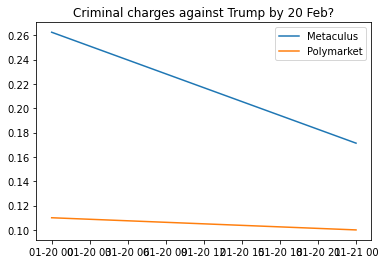

In [9]:
plot_predictions(trump_charges, 'Criminal charges against Trump by 20 Feb?').show()

## GOP Win

In [10]:
# https://www.metaculus.com/questions/5734/gop-to-hold-senate-on-feb-1st-2021/
gop_senate = compare_metaculus_vs_polymarket('https://polymarket.com/market/which-party-will-control-the-senate',
                                             5734,
                                             actual=0)

Fetching...
Fetched


In [11]:
gop_senate['data']

,time,metaculus_yes,polymarket_yes,metaculus_brier,polymarket_brier,50_50_yes,50_50_brier,metaculus_bets,metaculus_winnings,polymarket_bets,polymarket_winnings
26,2020-12-16,0.768302,0.67,0.590288,0.4489,0.719151,0.517178,297.884405,404.231190,127.946917,1424.266897
27,2020-12-17,0.769507,0.69,0.592140,0.4761,0.729753,0.532540,256.472618,487.054764,103.321428,1344.940380
28,2020-12-18,0.769517,0.68,0.592157,0.4624,0.724759,0.525275,279.741436,440.517129,116.329112,1388.390294
29,2020-12-19,0.771369,0.68,0.595009,0.4624,0.725684,0.526618,285.526632,428.946737,118.449897,1399.632295
30,2020-12-20,0.785703,0.68,0.617329,0.4624,0.732851,0.537071,330.321060,339.357880,134.532736,1493.252872
31,2020-12-21,0.788872,0.69,0.622319,0.4761,0.739436,0.546766,318.941718,362.116565,125.333313,1468.303119
32,2020-12-22,0.790197,0.70,0.624411,0.4900,0.745098,0.555172,300.656045,398.687911,114.144745,1429.911551
33,2020-12-23,0.789316,0.69,0.623020,0.4761,0.739658,0.547094,320.375191,359.249618,125.825741,1471.400082
34,2020-12-24,0.789316,0.69,0.623020,0.4761,0.739658,0.547094,320.375191,359.249618,125.825741,1471.400082
35,2020-12-25,0.783695,0.70,0.614178,0.4900,0.741848,0.550338,278.984138,442.031725,106.795648,1386.932039


In [12]:
gop_senate['brier']

metaculus_brier     0.577327
polymarket_brier    0.413390
50_50_brier         0.491621
dtype: float64

In [13]:
gop_senate['winnings']

metaculus_winnings      343.801624
polymarket_winnings    1501.937726
dtype: float64

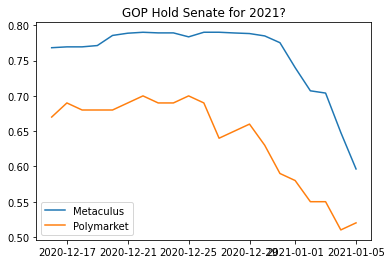

In [14]:
plot_predictions(gop_senate, 'GOP Hold Senate for 2021?').show()

## Trump Pardon

In [15]:
# https://www.metaculus.com/questions/5685/will-donald-trump-attempt-to-pardon-himself/
trump_pardon = compare_metaculus_vs_polymarket('https://polymarket.com/market/will-trump-pardon-himself-in-his-first-term',
                                               5685,
                                               actual=0)

Fetching...
Fetched


In [16]:
trump_pardon['data']

,time,metaculus_yes,polymarket_yes,metaculus_brier,polymarket_brier,50_50_yes,50_50_brier,metaculus_bets,metaculus_winnings,polymarket_bets,polymarket_winnings
11,2020-11-24,0.151126,0.15,0.022839,0.0225,0.150563,0.022669,1.324808,997.350383,7.451309,1001.326566
12,2020-11-25,0.153572,0.23,0.023585,0.0529,0.191786,0.036782,332.293568,1099.256520,90.294229,819.411541
13,2020-11-26,0.151968,0.26,0.023094,0.0676,0.205984,0.042429,415.506004,1145.988596,127.390968,745.218065
14,2020-11-27,0.151968,0.21,0.023094,0.0441,0.180984,0.032755,276.340767,1073.457672,68.430898,863.138204
15,2020-11-28,0.151968,0.22,0.023094,0.0484,0.185984,0.034590,309.234368,1087.219950,80.222912,839.554177
16,2020-11-29,0.151968,0.22,0.023094,0.0484,0.185984,0.034590,309.234368,1087.219950,80.222912,839.554177
17,2020-11-30,0.156464,0.21,0.024481,0.0441,0.183232,0.033574,254.933437,1067.767116,63.466195,873.067609
18,2020-12-01,0.135531,0.24,0.018369,0.0576,0.187765,0.035256,435.288554,1137.459543,120.847853,758.304295
19,2020-12-02,0.173219,0.29,0.030005,0.0841,0.231609,0.053643,402.694683,1164.480927,141.248279,717.503442
20,2020-12-03,0.184995,0.27,0.034223,0.0729,0.227497,0.051755,314.835151,1116.445878,104.300513,791.398974


In [17]:
trump_pardon['brier']

metaculus_brier     0.049783
polymarket_brier    0.093529
50_50_brier         0.068785
dtype: float64

In [18]:
trump_pardon['winnings']

metaculus_winnings     1122.854447
polymarket_winnings     776.155296
dtype: float64

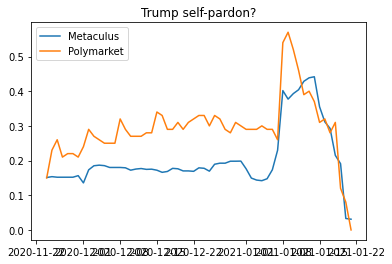

In [19]:
plot_predictions(trump_pardon, 'Trump self-pardon?').show()

## 538 - Economist

In [20]:
# https://www.metaculus.com/questions/5503/comparing-538-and-economist-forecasts-in-2020/
economist_538 = compare_metaculus_vs_polymarket('https://polymarket.com/market/will-538-outperform-the-economist-in-forecasting-the-2020-presidential-election',
                                                5503,
                                                actual=0)

Fetching...
Fetched


In [21]:
economist_538['data']

,time,metaculus_yes,polymarket_yes,metaculus_brier,polymarket_brier,50_50_yes,50_50_brier,metaculus_bets,metaculus_winnings,polymarket_bets,polymarket_winnings
4,2020-10-28,0.332055,0.60,0.110260,0.3600,0.466027,0.217181,446.575559,1669.863338,401.148599,197.702802
5,2020-10-29,0.335926,0.55,0.112846,0.3025,0.442963,0.196216,389.225776,1475.720393,322.364857,355.270287
6,2020-10-30,0.361631,0.53,0.130777,0.2809,0.445815,0.198751,317.677786,1358.232397,263.748971,472.502058
7,2020-10-31,0.350442,0.51,0.122809,0.2601,0.430221,0.185090,312.859751,1325.629537,245.641431,508.717137
8,2020-11-01,0.353388,0.55,0.124883,0.3025,0.451694,0.204028,357.475560,1436.914574,304.064404,391.871192
9,2020-11-02,0.351041,0.55,0.123230,0.3025,0.450520,0.202969,361.744365,1442.132002,306.582200,386.835600


In [22]:
economist_538['brier']

metaculus_brier     0.120801
polymarket_brier    0.301417
50_50_brier         0.200706
dtype: float64

In [23]:
economist_538['winnings']

metaculus_winnings     1451.415373
polymarket_winnings     385.483179
dtype: float64

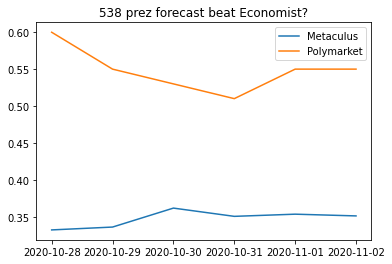

In [24]:
plot_predictions(economist_538, '538 prez forecast beat Economist?').show()

## Biden in-person inauguration

In [25]:
## https://www.metaculus.com/questions/6293/biden-in-person-inauguration/
biden_in_person = compare_metaculus_vs_polymarket('https://polymarket.com/market/will-joe-biden-be-officially-inaugurated-as-president-in-person-outside-the-us-capitol-on-january-20th-2021',
                                                  6293,
                                                  actual=1)

Fetching...
Fetched


In [26]:
biden_in_person['data']

,time,metaculus_yes,polymarket_yes,metaculus_brier,polymarket_brier,50_50_yes,50_50_brier,metaculus_bets,metaculus_winnings,polymarket_bets,polymarket_winnings
0,2021-01-17,0.968120,0.88,0.001016,0.0144,0.924060,0.005767,734.334731,1100.136554,91.021932,817.956137
1,2021-01-18,0.944414,0.92,0.003090,0.0064,0.932207,0.004596,305.174827,1026.536942,25.850937,948.298127
2,2021-01-19,0.934612,0.93,0.004276,0.0049,0.932306,0.004582,65.884592,1004.959055,4.934584,990.130831


In [27]:
biden_in_person['brier']

metaculus_brier     0.002794
polymarket_brier    0.008567
50_50_brier         0.004982
dtype: float64

In [28]:
biden_in_person['winnings']

metaculus_winnings     1043.877517
polymarket_winnings     918.795031
dtype: float64

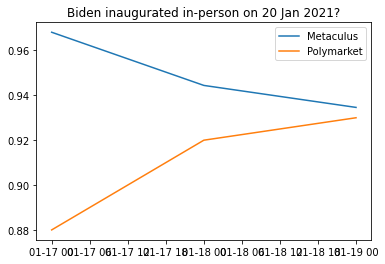

In [29]:
plot_predictions(biden_in_person, 'Biden inaugurated in-person on 20 Jan 2021?').show()

## Trump at Biden's Inauguration

In [30]:
## https://www.metaculus.com/questions/5825/trump-at-bidens-inauguration/
trump_attend = compare_metaculus_vs_polymarket('https://polymarket.com/market/will-donald-trump-attend-joe-biden-s-inauguration-ceremony-in-person',
                                               5825,
                                               actual=0)

Fetching...
Fetched


In [31]:
trump_attend['data']

,time,metaculus_yes,polymarket_yes,metaculus_brier,polymarket_brier,50_50_yes,50_50_brier,metaculus_bets,metaculus_winnings,polymarket_bets,polymarket_winnings
0,2020-12-05,0.013227,0.15,0.000175,0.0225,0.081613,0.006661,911.820175,1160.909443,138.606369,722.787262
1,2020-12-06,0.128050,0.15,0.016397,0.0225,0.139025,0.019328,146.334952,1025.823815,25.173733,949.652534
2,2020-12-07,0.108840,0.14,0.011846,0.0196,0.124420,0.015480,222.569930,1036.232314,34.965436,930.069129
3,2020-12-08,0.102595,0.13,0.010526,0.0169,0.116297,0.013525,210.809549,1031.500277,30.538312,938.923376
4,2020-12-09,0.089913,0.13,0.008084,0.0169,0.109957,0.012090,308.359654,1046.076730,44.047180,911.905640
5,2020-12-10,0.077684,0.14,0.006035,0.0196,0.108842,0.011847,445.117616,1072.461007,67.565167,864.869666
6,2020-12-11,0.075557,0.17,0.005709,0.0289,0.122778,0.015075,555.548527,1113.787048,102.162301,795.675398
7,2020-12-12,0.075124,0.19,0.005644,0.0361,0.132562,0.017573,604.611259,1141.822394,124.207053,751.585895
8,2020-12-13,0.074646,0.10,0.005572,0.0100,0.087323,0.007625,253.540905,1028.171212,27.399339,945.201322
9,2020-12-14,0.075540,0.16,0.005706,0.0256,0.117770,0.013870,527.874284,1100.547483,91.361331,817.277338


In [32]:
trump_attend['brier']

metaculus_brier     0.002814
polymarket_brier    0.018043
50_50_brier         0.008232
dtype: float64

In [33]:
trump_attend['winnings']

metaculus_winnings     1096.198166
polymarket_winnings     829.462163
dtype: float64

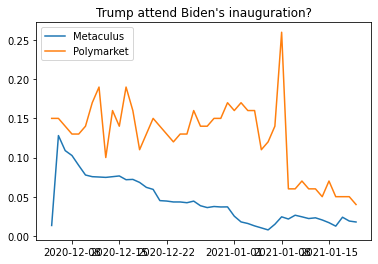

In [34]:
plot_predictions(trump_attend, 'Trump attend Biden\'s inauguration?').show()

## Electoral Challenge

In [35]:
## https://www.metaculus.com/questions/5844/electoral-college-results-challenged/
challenge = compare_metaculus_vs_polymarket('https://polymarket.com/market/will-any-electoral-certificates-be-formally-challenged-in-congress',
                                            5844,
                                            actual=1)

Fetching...
Fetched


ValueError: Length mismatch: Expected axis has 0 elements, new values have 3 elements

In [ ]:
challenge['data']

In [ ]:
challenge['brier']

In [ ]:
challenge['winnings']

In [ ]:
plot_predictions(challenge, 'Electoral college challenge?').show()

## Trump Convict

In [36]:
## https://www.metaculus.com/questions/6303/trump-convicted-by-senate/
trump_convict = compare_metaculus_vs_polymarket('https://polymarket.com/market/will-the-senate-convict-donald-trump-on-impeachment-before-june-1-2021',
                                                6303,
                                                actual=0)

Fetching...
Fetched


ValueError: Length mismatch: Expected axis has 0 elements, new values have 3 elements

In [ ]:
trump_convict['data']

In [ ]:
trump_convict['brier']

In [ ]:
trump_convict['winnings']

In [ ]:
plot_predictions(trump_convict, 'Senate convict Trump in 2021?').show()

## Tokyo Olympics

In [ ]:
# https://polymarket.com/market/will-the-tokyo-summer-olympics-be-cancelled-or-postponed
# https://www.metaculus.com/questions/5555/rescheduled-2020-olympics/

## Brier

In [ ]:
(challenge['brier'] + trump_attend['brier'] + biden_in_person['brier'] + economist_538['brier'] +
trump_pardon['brier'] + gop_senate['brier'] + trump_charges['brier'] + trump_convict['brier']) / 8

In [ ]:
(challenge['winnings'] + trump_attend['winnings'] + biden_in_person['winnings'] + economist_538['winnings'] +
trump_pardon['winnings'] + gop_senate['winnings'] + trump_charges['winnings'] + trump_convict['winnings']) / 8